In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks
from synthcity.plugins.core.dataloader import GenericDataLoader


sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'figure.dpi': 100,
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14
})

In [2]:
DATA_DIR = "Imbalanced_Datasets/Hepatitis_C_Virus/"
BALANCED_DATA_PATH = os.path.join(DATA_DIR, "hcv_dataset_ir_1.csv")
TARGET_COLUMN = "Fibrosis_Stage_Label"
RANDOM_STATE = 42
TEST_SET_SIZE = 0.3

GENERATIVE_MODELS = ["ctgan", "tvae", "rtvae"]

In [3]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies label encoding to all object/categorical columns in the dataframe,
    ensuring it's ready for machine learning models.
    """
    df_processed = df.copy()
    
    for col in df_processed.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        
    return df_processed

def plot_results(df: pd.DataFrame, metrics: list, title: str, filename: str):
    """
    Generates and saves line plots for specified metrics vs. Imbalance Ratio.
    """
    n_metrics = len(metrics)
    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 6 * n_metrics), sharex=True)
    if n_metrics == 1:
        axes = [axes] 

    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(
            data=df,
            x='IR',
            y=metric,
            hue='Model',
            style='Model',
            marker='o',
            markersize=8,
            ax=ax
        )
        ax.set_title(f'Analysis of {metric}')
        ax.set_ylabel(metric)
        ax.set_xlabel('Imbalance Ratio (IR) - Log Scale')
        ax.set_xscale('log')
        ax.set_xticks(df['IR'].unique())
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax.grid(True, which="both", ls="--")
        ax.legend(title='Generative Model')
        
    plt.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Plot saved to '{filename}'")
    plt.show()


print(" Starting Synthetic Data Quality Benchmark ")

print(f"Loading balanced dataset from: {BALANCED_DATA_PATH}")
df_balanced = pd.read_csv(BALANCED_DATA_PATH)
df_processed_balanced = preprocess_data(df_balanced)

# Create a stratified hold-out test set to ensure fair and unbiased evaluation
X = df_processed_balanced.drop(columns=[TARGET_COLUMN])
y = df_processed_balanced[TARGET_COLUMN]
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=TEST_SET_SIZE, random_state=RANDOM_STATE, stratify=y
)
df_test = pd.concat([X_test, y_test], axis=1)
test_loader = GenericDataLoader(df_test, target_column=TARGET_COLUMN)
print(f"Hold-out test set created. Shape: {df_test.shape}")
print("Test set class distribution:\n", df_test[TARGET_COLUMN].value_counts().sort_index())
print("-" * 50)

imbalanced_files = glob.glob(os.path.join(DATA_DIR, "hcv_dataset_ir_*.csv"))
imbalanced_datasets = {}

for file_path in sorted(imbalanced_files, key=lambda x: int(re.search(r'ir_(\d+)', x).group(1))):
    if (ir_match := re.search(r'ir_(\d+)', file_path)):
        ir = int(ir_match.group(1))
        print(f"Loading training set for IR={ir}...")
        df_train = pd.read_csv(file_path)
        imbalanced_datasets[ir] = preprocess_data(df_train)

print(f"\nLoaded {len(imbalanced_datasets)} training datasets with IRs: {list(imbalanced_datasets.keys())}")
print("-" * 50)



 Starting Synthetic Data Quality Benchmark 
Loading balanced dataset from: Imbalanced_Datasets/Hepatitis_C_Virus/hcv_dataset_ir_1.csv
Hold-out test set created. Shape: (416, 30)
Test set class distribution:
 Fibrosis_Stage_Label
0    101
1    100
2    106
3    109
Name: count, dtype: int64
--------------------------------------------------
Loading training set for IR=1...
Loading training set for IR=2...
Loading training set for IR=5...
Loading training set for IR=10...
Loading training set for IR=20...
Loading training set for IR=50...

Loaded 6 training datasets with IRs: [1, 2, 5, 10, 20, 50]
--------------------------------------------------


In [4]:

results_list = []

for ir, train_df in imbalanced_datasets.items():
    print(f"\n{'='*25} Benchmarking for Imbalance Ratio (IR) = {ir} {'='*25}")
    print(f"Training data shape: {train_df.shape}")
    
    train_loader = GenericDataLoader(train_df, target_column=TARGET_COLUMN)
    evaluation_tasks = [(f"{model}_ir{ir}", model, {}) for model in GENERATIVE_MODELS]

    metrics_suite = {
        "fidelity": ["alpha_precision"],
        "utility": ["detection_xgb"],
        "privacy": ["dcr_recap"],
    }

    try:
        score = Benchmarks.evaluate(
            tests=evaluation_tasks,
            X=train_loader,
            X_test=test_loader,
            synthetic_size=len(train_df),
            metrics=metrics_suite,
            task_type="classification",
            repeats=1,
            device="cpu",
            random_state=RANDOM_STATE,
            workspace="."
        )
        
        for model in GENERATIVE_MODELS:
            test_name = f"{model}_ir{ir}"
            
            alpha_precision = score[test_name]['fidelity']['alpha_precision']['mean']
            aucroc = score[test_name]['utility']['detection_xgb']['aucroc']['mean']
            f1_macro = score[test_name]['utility']['detection_xgb']['f1_score_macro']['mean']
            dcr = score[test_name]['privacy']['dcr_recap']['mean']

            results_list.append({
                "IR": ir,
                "Model": model.upper(),
                "Alpha Precision (Fidelity)": alpha_precision,
                "AUROC (Utility)": aucroc,
                "F1 Macro (Utility)": f1_macro,
                "DCR (Privacy)": dcr
            })
            
    except Exception as e:
        print(f"ERROR during benchmarking for IR={ir}: {type(e).__name__} - {e}. Skipping this run.")



========================= Benchmarking for Imbalance Ratio (IR) = 1 =========================
Training data shape: (1385, 30)


[2025-09-11T11:43:12.036248+0100][5922][CRITICAL] Error importing TabularGoggle: No module named 'torchdata.datapipes'
[2025-09-11T11:43:12.058099+0100][5922][CRITICAL] module disabled: /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
 37%|███▋      | 749/2000 [09:17<15:31,  1.34it/s]  
[2025-09-11T11:52:44.705751+0100][5922][CRITICAL] module disabled: /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-09-11T11:52:44.705751+0100][5922][CRITICAL] module disabled: /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
 30%|███       | 300/1000 [03:07<07:18,  1.60it/s]
[2025-09-11T11:56:09.417050+0100][5922][CRITICAL] module disabled: /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-09-11T11:56:09.417050+0

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:17                                                                                   │
│                                                                                                  │
│   14 │   }                                                                                       │
│   15 │                                                                                           │
│   16 │   try:                                                                                    │
│ ❱ 17 │   │   score = Benchmarks.evaluate(                                                        │
│   18 │   │   │   tests=evaluation_tasks,                                                         │
│   19 │   │   │   X=train_loader,                                                                 │
│   20 │   │   │   X_test=test_loader,                                                             │
│                                                                                                  │
│ /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/pydantic/deprecated │
│ /decorator.py:56 in wrapper_function                                                             │
│                                                                                                  │
│    53 │   │                                                                                      │
│    54 │   │   @wraps(_func)                                                                      │
│    55 │   │   def wrapper_function(*args: Any, **kwargs: Any) -> Any:                            │
│ ❱  56 │   │   │   return vd.call(*args, **kwargs)                                                │
│    57 │   │                                                                                      │
│    58 │   │   wrapper_function.vd = vd  # type: ignore                                           │
│    59 │   │   wrapper_function.validate = vd.init_model_instance  # type: ignore                 │
│                                                                                                  │
│ /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/pydantic/deprecated │
│ /decorator.py:151 in call                                                                        │
│                                                                                                  │
│   148 │                                                                                          │
│   149 │   def call(self, *args: Any, **kwargs: Any) -> Any:                                      │
│   150 │   │   m = self.init_model_instance(*args, **kwargs)                                      │
│ ❱ 151 │   │   return self.execute(m)                                                             │
│   152 │                                                                                          │
│   153 │   def build_values(self, args: tuple[Any, ...], kwargs: dict[str, Any]) -> dict[str, A   │
│   154 │   │   values: dict[str, Any] = {}                                                        │
│                                                                                                  │
│ /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/pydantic/deprecated │
│ /decorator.py:227 in execute                                                                     │
│                                                                                                  │
│   224 │   │   │   │   │   kwargs[name] = value                                                   │
│   225 │   │   │   return self.raw_function(*args_, **kwargs, **var_kwargs)                       │
│   226 │   │   else:                                                                              │
│ ❱ 227 │   │   │   return self.raw_function(**d, **var_kwarg



Benchmark Complete. Final Results:
Empty DataFrame
Columns: []
Index: []

Results saved to 'hcv_imbalance_benchmark_results.csv'


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 results_df.to_csv("hcv_imbalance_benchmark_results.csv", index=False)                       │
│    7 print("\nResults saved to 'hcv_imbalance_benchmark_results.csv'")                           │
│    8                                                                                             │
│ ❱  9 plot_results(                                                                               │
│   10 │   results_df,                                                                             │
│   11 │   metrics=["AUROC (Utility)", "F1 Macro (Utility)"],                                      │
│   12 │   title="Model Utility vs. Imbalance Ratio",                                              │
│                                                                                                  │
│ in plot_results:25                                                                               │
│                                                                                                  │
│   22 │                                                                                           │
│   23 │   for i, metric in enumerate(metrics):                                                    │
│   24 │   │   ax = axes[i]                                                                        │
│ ❱ 25 │   │   sns.lineplot(                                                                       │
│   26 │   │   │   data=df,                                                                        │
│   27 │   │   │   x='IR',                                                                         │
│   28 │   │   │   y=metric,                                                                       │
│                                                                                                  │
│ /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/seaborn/relational. │
│ py:485 in lineplot                                                                               │
│                                                                                                  │
│   482 │   # Handle deprecation of ci parameter                                                   │
│   483 │   errorbar = _deprecate_ci(errorbar, ci)                                                 │
│   484 │                                                                                          │
│ ❱ 485 │   p = _LinePlotter(                                                                      │
│   486 │   │   data=data,                                                                         │
│   487 │   │   variables=dict(                                                                    │
│   488 │   │   │   x=x, y=y, hue=hue, size=size, style=style, units=units, weight=weights         │
│                                                                                                  │
│ /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/seaborn/relational. │
│ py:216 in __init__                                                                               │
│                                                                                                  │
│   213 │   │   │   np.r_[.5, 2] * mpl.rcParams["lines.linewidth"]                                 │
│   214 │   │   )                                                                                  │
│   215 │   │                                                                                      │
│ ❱ 216 │   │   super().__init__(data=data, variables=variables)                                   │
│   217 │   │                                                

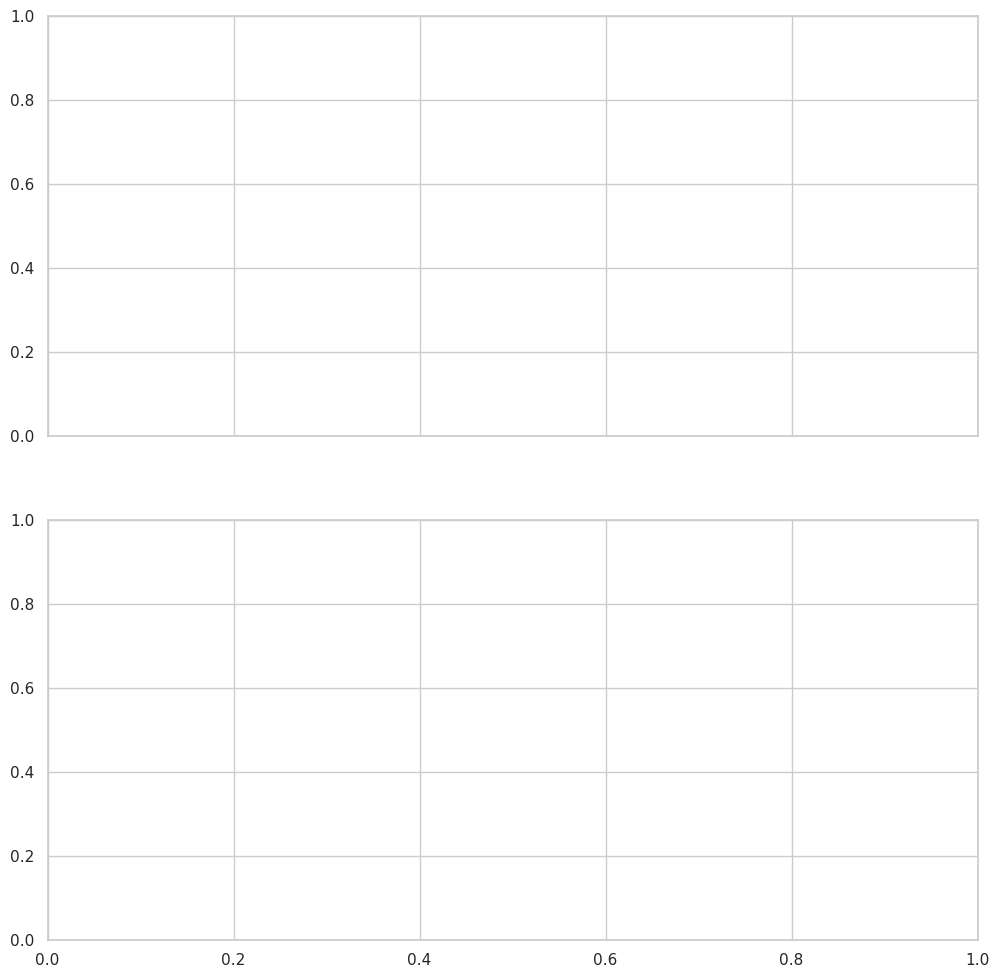

In [ ]:
results_df = pd.DataFrame(results_list)

print("\n\nBenchmark Complete. Final Results:")
print(results_df.round(4).to_string())

results_df.to_csv("hcv_imbalance_benchmark_results.csv", index=False)
print("\nResults saved to 'hcv_imbalance_benchmark_results.csv'")

plot_results(
    results_df,
    metrics=["AUROC (Utility)", "F1 Macro (Utility)"],
    title="Model Utility vs. Imbalance Ratio",
    filename="model_utility_evaluation.png"
)
plot_results(
    results_df,
    metrics=["Alpha Precision (Fidelity)"],
    title="Data Fidelity vs. Imbalance Ratio",
    filename="data_fidelity_evaluation.png"
)
plot_results(
    results_df,
    metrics=["DCR (Privacy)"],
    title="Data Privacy vs. Imbalance Ratio",
    filename="data_privacy_evaluation.png"
)

print("\n Benchmark Finished Successfully ")